
Calculating Weekly Beta, Correlation, and Standard Deviation...

Weekly Beta Values (last 5 rows):
                                QQQ
Date                               
2025-08-03 00:00:00+00:00  0.252570
2025-08-10 00:00:00+00:00  0.256507
2025-08-17 00:00:00+00:00  0.260891
2025-08-24 00:00:00+00:00  0.268809
2025-08-31 00:00:00+00:00  0.282813

Weekly Correlation Values (last 5 rows):
                                QQQ
Date                               
2025-08-03 00:00:00+00:00  0.474297
2025-08-10 00:00:00+00:00  0.478053
2025-08-17 00:00:00+00:00  0.498692
2025-08-24 00:00:00+00:00  0.506046
2025-08-31 00:00:00+00:00  0.513434

Weekly Standard Deviation Values (last 5 rows, %):
                            BTC-USD       QQQ
Date                                         
2025-08-03 00:00:00+00:00  6.021846  3.206718
2025-08-10 00:00:00+00:00  6.035519  3.238457
2025-08-17 00:00:00+00:00  6.044932  3.162412
2025-08-24 00:00:00+00:00  5.961663  3.166805
2025-08-31 00:00:00+00:00 

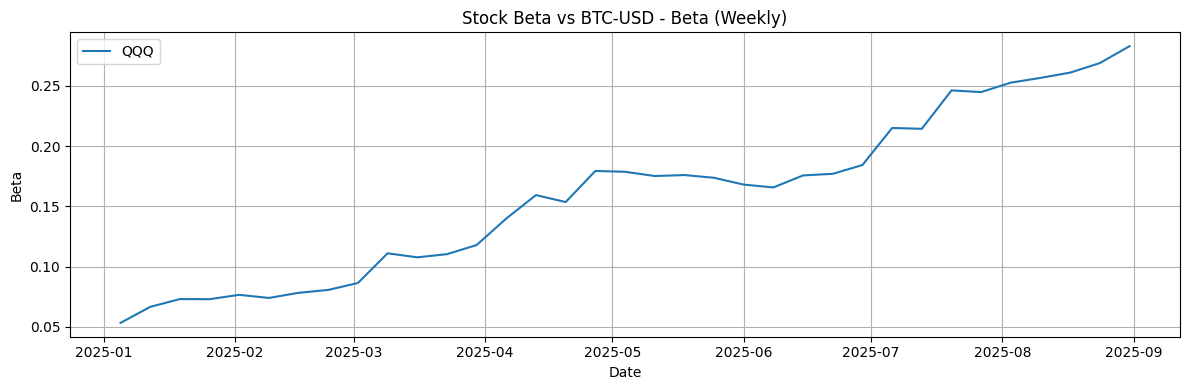

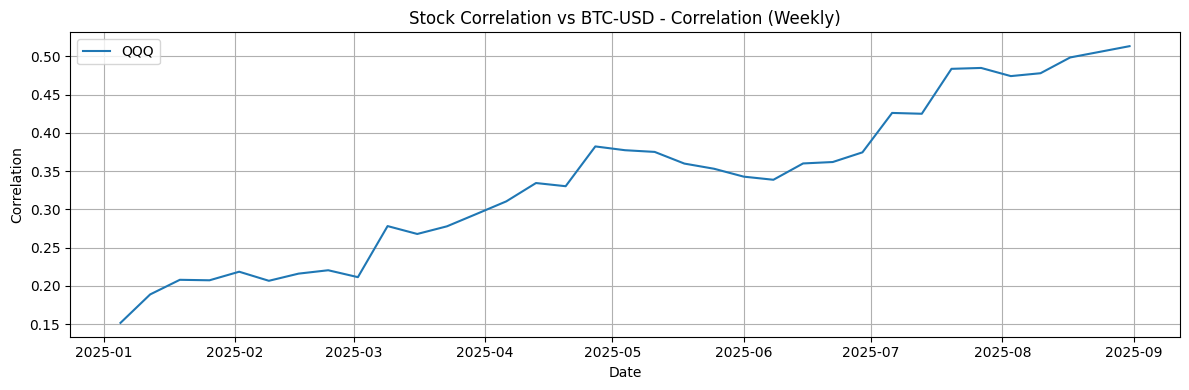

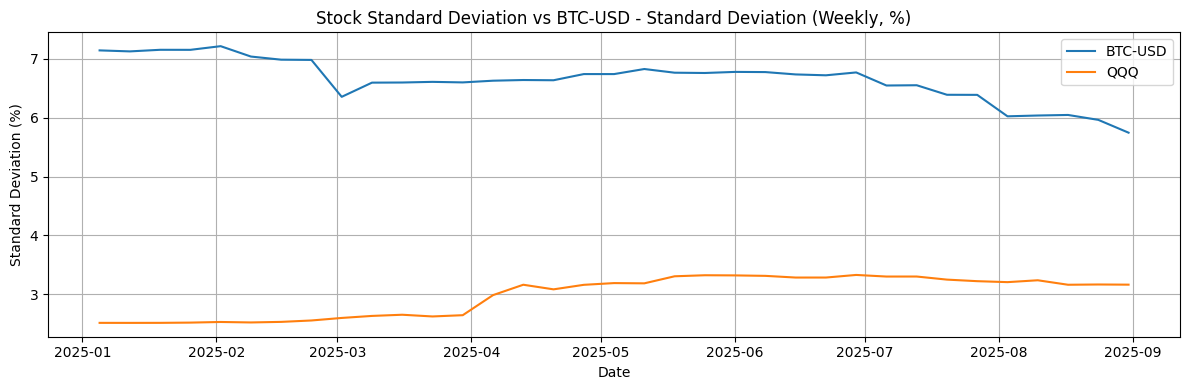

In [7]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import os
import numpy as np
import matplotlib.pyplot as plt

def get_stock_data(ticker, start_date, end_date):
    """獲取指定股票或指數的歷史數據，包含股息"""
    try:
        data = yf.Ticker(ticker).history(start=start_date, end=end_date, actions=True)
        if data.empty:
            raise ValueError(f"No data found for ticker {ticker} between {start_date} and {end_date}")
        if data.index.tz is None:
            data.index = data.index.tz_localize('UTC')
        else:
            data.index = data.index.tz_convert('UTC')
        data.index = data.index.normalize()
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def calculate_beta_and_correlation(tickers, benchmark, start_date, end_date, window=252, freq='D'):
    """
    計算多個資產相對於基準指數的beta值、相關性和標準差
    tickers: 資產代碼列表
    benchmark: 基準指數代碼
    window: 滾動窗口大小（交易日數）
    freq: 數據頻率 ('D' for daily, 'W' for weekly, 'M' for monthly)
    """
    # 獲取基準指數數據
    benchmark_data = get_stock_data(benchmark, start_date, end_date)
    if benchmark_data is None:
        return None, None, None
    
    # 根據頻率重新採樣
    if freq != 'D':
        benchmark_data = benchmark_data.resample(freq).last()
    
    # 計算基準指數日回報率
    benchmark_returns = benchmark_data['Close'].pct_change().dropna()
    
    # 初始化beta、correlation和std數據框
    beta_df = pd.DataFrame()
    corr_df = pd.DataFrame()
    std_df = pd.DataFrame()
    
    # 計算基準指數的標準差（轉為百分數）
    benchmark_std = benchmark_returns.rolling(window=window).std() * 100
    
    std_df[benchmark] = benchmark_std
    
    for ticker in tickers:
        # 獲取個股數據
        stock_data = get_stock_data(ticker, start_date, end_date)
        if stock_data is None:
            continue
            
        # 根據頻率重新採樣
        if freq != 'D':
            stock_data = stock_data.resample(freq).last()
            
        # 計算日回報率
        stock_returns = stock_data['Close'].pct_change().dropna()
        
        # 計算標準差（轉為百分數）
        stock_std = stock_returns.rolling(window=window).std() * 100
        std_df[ticker] = stock_std
        
        # 合併回報率數據
        combined = pd.concat([stock_returns, benchmark_returns], 
                           axis=1, 
                           join='inner')
        combined.columns = [ticker, benchmark]
        
        # 計算滾動beta
        cov = combined[ticker].rolling(window=window).cov(combined[benchmark])
        var = combined[benchmark].rolling(window=window).var()
        beta = cov / var
        
        # 計算滾動相關性
        correlation = combined[ticker].rolling(window=window).corr(combined[benchmark])
        
        # 添加到結果數據框
        beta_df[ticker] = beta
        corr_df[ticker] = correlation
    
    return beta_df, corr_df, std_df

def plot_beta(beta_df, title="Asset Beta Over Time", freq='Weekly'):
    """繪製beta值線圖"""
    plt.figure(figsize=(12, 4))
    for column in beta_df.columns:
        plt.plot(beta_df.index, beta_df[column], label=f"{column}")
    plt.title(f"{title} - Beta ({freq})")
    plt.xlabel('Date')
    plt.ylabel('Beta')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_correlation(corr_df, title="Asset Correlation Over Time", freq='Weekly'):
    """繪製相關性線圖"""
    plt.figure(figsize=(12, 4))
    for column in corr_df.columns:
        plt.plot(corr_df.index, corr_df[column], label=f"{column}")
    plt.title(f"{title} - Correlation ({freq})")
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_standard_deviation(std_df, title="Asset Standard Deviation Over Time", freq='Weekly'):
    """繪製標準差線圖（百分數）"""
    plt.figure(figsize=(12, 4))
    for column in std_df.columns:
        plt.plot(std_df.index, std_df[column], label=f"{column}")
    plt.title(f"{title} - Standard Deviation ({freq}, %)")
    plt.xlabel('Date')
    plt.ylabel('Standard Deviation (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_and_plot_weekly(tickers, benchmark, start_date, end_date):
    """
    計算並繪製Weekly週期的beta值、相關性和標準差，圖表分開顯示
    """
    period_name = 'Weekly'
    config = {'window': 52, 'freq': 'W'}
    
    print(f"\nCalculating {period_name} Beta, Correlation, and Standard Deviation...")
    beta_df, corr_df, std_df = calculate_beta_and_correlation(tickers, benchmark, start_date, end_date, 
                                                            window=config['window'], freq=config['freq'])
    
    if beta_df is not None and corr_df is not None and std_df is not None:
        print(f"\n{period_name} Beta Values (last 5 rows):")
        print(beta_df.tail())
        print(f"\n{period_name} Correlation Values (last 5 rows):")
        print(corr_df.tail())
        print(f"\n{period_name} Standard Deviation Values (last 5 rows, %):")
        print(std_df.tail())
        plot_beta(beta_df, f"Stock Beta vs {benchmark}", period_name)
        plot_correlation(corr_df, f"Stock Correlation vs {benchmark}", period_name)
        plot_standard_deviation(std_df, f"Stock Standard Deviation vs {benchmark}", period_name)

# 示例使用
if __name__ == "__main__":
    # 設置參數
    tickers = ['QQQ']  # VGTSX (全球股市), VBMFX (債券市場)
    benchmark = 'BTC-USD'  # 標普500指數作為基準
    start_date = datetime(2024, 1, 1)  # 直接指定開始日期
    end_date = datetime.now()  # 當前日期作為結束日期
    
    # 計算並繪製Weekly週期的beta、相關性和標準差
    calculate_and_plot_weekly(tickers, benchmark, start_date, end_date)

In [8]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

def get_stock_data(ticker, start_date, end_date):
    """獲取指定股票或指數的歷史數據"""
    try:
        data = yf.Ticker(ticker).history(start=start_date, end=end_date, actions=True)
        if data.empty:
            raise ValueError(f"No data found for ticker {ticker} between {start_date} and {end_date}")
        if data.index.tz is None:
            data.index = data.index.tz_localize('UTC')
        else:
            data.index = data.index.tz_convert('UTC')
        data.index = data.index.normalize()
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def calculate_beta(tickers, benchmark, start_date, end_date, window=252, freq='D'):
    """
    計算多個資產相對於基準指數的beta值
    tickers: 資產代碼列表
    benchmark: 基準指數代碼
    window: 滾動窗口大小（交易天數）
    freq: 數據頻率 ('D' for daily)
    """
    # 獲取基準指數數據
    benchmark_data = get_stock_data(benchmark, start_date, end_date)
    if benchmark_data is None:
        return None
    
    # 根據頻率重新採樣（每日數據無需重採樣）
    if freq != 'D':
        benchmark_data = benchmark_data.resample(freq).last()
    
    # 計算基準指數日回報率
    benchmark_returns = benchmark_data['Close'].pct_change().dropna()
    
    # 初始化beta數據框
    beta_df = pd.DataFrame()
    
    for ticker in tickers:
        # 獲取個股數據
        stock_data = get_stock_data(ticker, start_date, end_date)
        if stock_data is None:
            continue
            
        # 根據頻率重新採樣
        if freq != 'D':
            stock_data = stock_data.resample(freq).last()
            
        # 計算日回報率
        stock_returns = stock_data['Close'].pct_change().dropna()
        
        # 合併回報率數據
        combined = pd.concat([stock_returns, benchmark_returns], 
                           axis=1, 
                           join='inner')
        combined.columns = [ticker, benchmark]
        
        # 計算滾動beta
        cov = combined[ticker].rolling(window=window).cov(combined[benchmark])
        var = combined[benchmark].rolling(window=window).var()
        beta = cov / var
        
        # 添加到結果數據框
        beta_df[ticker] = beta
    
    return beta_df

def calculate_average_beta(beta_df, weights, combination_name):
    """
    計算資產組合的加權平均beta值
    beta_df: 包含各資產beta值的數據框
    weights: 資產權重列表（與beta_df的列對應）
    combination_name: 組合名稱
    """
    if beta_df is None or beta_df.empty:
        return None
    
    # 確保權重數量與beta_df列數一致
    if len(weights) != len(beta_df.columns):
        print(f"Error: Number of weights ({len(weights)}) does not match number of assets ({len(beta_df.columns)})")
        return None
    
    # 計算加權平均beta
    weighted_beta = beta_df.mul(weights, axis=1).sum(axis=1)
    return pd.DataFrame({combination_name: weighted_beta})

def plot_average_beta(avg_beta_dfs, tickers, combinations, title="Portfolio Average Beta Over Time", freq='Daily'):
    """繪製各資產組合的平均beta值線圖，圖例顯示資產比例（乘以100，無百分比符號）"""
    plt.figure(figsize=(12, 6))
    
    for combination_name, avg_beta_df in avg_beta_dfs.items():
        if avg_beta_df is not None and not avg_beta_df.empty:
            # 獲取該組合的權重
            weights = combinations[combination_name]
            # 將權重乘以100並轉為整數，格式為逗號分隔
            weights_str = ', '.join([str(int(w * 100)) for w in weights])
            # 圖例標籤：組合名稱 + 權重
            label = f"{combination_name} [{weights_str}]"
            plt.plot(avg_beta_df.index, avg_beta_df[combination_name], label=label)
    
    # 將tickers加入標題
    tickers_str = ', '.join(tickers)
    plt.title(f"{title} for {tickers_str} ({freq})")
    plt.xlabel('Date')
    plt.ylabel('Average Beta')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_average_beta(avg_beta_dfs, tickers, combinations, title="Portfolio Average Beta Over Time", freq='Daily'):
    """繪製各資產組合的平均beta值線圖，跳過值為0的數據點，圖例顯示資產比例（乘以100，無百分比符號）"""
    plt.figure(figsize=(12, 6))
    
    for combination_name, avg_beta_df in avg_beta_dfs.items():
        if avg_beta_df is not None and not avg_beta_df.empty:
            # 篩選非零值
            non_zero_beta = avg_beta_df[avg_beta_df[combination_name] != 0]
            if non_zero_beta.empty:
                continue  # 如果篩選後數據為空，跳過該組合
                
            # 獲取該組合的權重
            weights = combinations[combination_name]
            # 將權重乘以100並轉為整數，格式為逗號分隔
            weights_str = ', '.join([str(int(w * 100)) for w in weights])
            # 圖例標籤：組合名稱 + 權重
            label = f"{combination_name} [{weights_str}]"
            plt.plot(non_zero_beta.index, non_zero_beta[combination_name], label=label)
    
    # 將tickers加入標題
    tickers_str = ', '.join(tickers)
    plt.title(f"{title} for {tickers_str} ({freq})")
    plt.xlabel('Date')
    plt.ylabel('Average Beta')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 示例使用
if __name__ == "__main__":
    # 設置參數
    tickers = ['SPY', 'SHV', 'SCHD', 'GLD']
    benchmark = '^SPX'  # 標普500指數作為基準
    start_date = datetime(2000, 1, 1)
    end_date = datetime.now()
    
    # 定義資產組合及其權重
    combinations = {
        'A': [0.6, 0.1, 0.1, 0.2],  
        'B': [0.6, 0.15, 0.15, 0.1], 
        'C': [0.6, 0.4, 0, 0],    
        'D': [0.6, 0, 0.4, 0]  
    }
    
    # 計算並繪製日平均beta
    calculate_and_plot_average_beta(tickers, benchmark, start_date, end_date, combinations)

NameError: name 'calculate_and_plot_average_beta' is not defined